## TODO
1. Prepare corpus + decide on splits and experiment design
1. Add multiple word embeddings to model_builder and configs
1. Save test predictions to disk for every model
1. Run all configs (start with CRF ones)

## Prepare corpus

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [4]:
from conlleval import evaluate

In [5]:
df = (pd.read_csv('curation.csv.gz')
      .assign(sent=lambda x: x.file+'_'+x.sent.astype(str)))

In [6]:
df.head()

,sent_tok_num,tok_offset,token,FEAT_gender,FEAT_number,FEAT_case,FEAT_degree,FEAT_transitivity,FEAT_tense,FEAT_mood,...,dep_flavor,dep_lex_morph_pos,dep_arc,EXTRA,sent,ner_layers,ner_type,is_ner,biose,file
0,1-1,0-5,עשרות,Fem,Plur,*,*,*,*,*,...,basic,1-2,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
1,1-2,6-11,אנשים,Masc,Plur,*,*,*,*,*,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
2,1-3,12-18,מגיעים,Masc,Plur,*,*,*,*,*,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
3,1-4,19-20,מ,_,_,_,_,_,_,_,...,basic,1-5,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
4,1-5,21-27,תאילנד,_,_,_,_,_,_,_,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,1,GPE,True,S-GPE,dev_1-100.tsv


In [7]:
df.head().T

,0,1,2,3,4
sent_tok_num,1-1,1-2,1-3,1-4,1-5
tok_offset,0-5,6-11,12-18,19-20,21-27
token,עשרות,אנשים,מגיעים,מ,תאילנד
FEAT_gender,Fem,Masc,Masc,_,_
FEAT_number,Plur,Plur,Plur,_,_
FEAT_case,*,*,*,_,_
FEAT_degree,*,*,*,_,_
FEAT_transitivity,*,*,*,_,_
FEAT_tense,*,*,*,_,_
FEAT_mood,*,*,*,_,_


In [8]:
x=df
sents = x.groupby('sent')[['token', 'pos', 'biose']].apply(lambda x: x.values.tolist())
sents[:5]

sent
dev_1-100.tsv_1      [[עשרות, NUM, O], [אנשים, NOUN, O], [מגיעים, V...
dev_1-100.tsv_10     [[ישראל, PROPN, B-PER], [ארד, PROPN, E-PER], [...
dev_1-100.tsv_100    [[טום, PROPN, B-PER], [הארקין, PROPN, E-PER], ...
dev_1-100.tsv_11     [[ח"כ, NOUN, O], [אלי, PROPN, B-PER], [דיין, P...
dev_1-100.tsv_12     [[חברות, NOUN, O], [ה, SCONJ, O], [מעסיקות, VE...
dtype: object

In [9]:
words = list(set(x["token"].values))
n_words = len(words); n_words

17824

In [10]:
tags = list(set(x["biose"].values))
n_tags = len(tags); n_tags

37

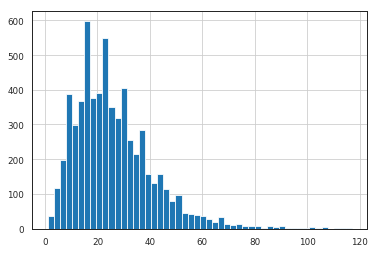

In [11]:
x.groupby('sent').size().hist(bins=50)

In [12]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [13]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sents]

Using TensorFlow backend.


In [14]:
X = pad_sequences(maxlen=max_len, sequences=X, value=word2idx["PAD"], padding='post', truncating='post')

In [15]:
X[1]

array([13525,  5670, 10268,  4015,   814,  3870,   814,  7148, 10268,
       11089,  4304, 12701, 17200,  5971,   814, 14247,   978,   814,
        7060, 10268,  8339,  9834, 10268, 11769, 10450, 14549, 11491,
       10953, 10268,  8479,  4767,   201,  9075,  3129, 17604, 17692,
         814, 10280, 13241,  4102, 14170, 12568,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [16]:
pos = list(set(x["pos"].values))
n_pos = len(pos); n_pos

16

In [17]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0
X_pos = [[pos2idx[w[1]] for w in s] for s in sents]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos[0]

array([12,  7, 11, 14,  8, 14,  8,  1, 13, 11, 14,  7,  2,  9,  3, 11,  7,
        6,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

## True tags

In [18]:
y = [[tag2idx[w[2]] for w in s] for s in sents]
y_numer = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [19]:
y_numer[1]

array([35, 30,  1,  1, 20, 11, 11, 24,  1,  1,  1,  1,  1,  1, 20, 11, 11,
       11, 24,  1, 35, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [20]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y_numer]
y[1]

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Perform train test splits

In [21]:
from sklearn.model_selection import train_test_split

splits = [train_test_split(X, y, X_pos, test_size=0.25, random_state=42+i) for i in range(3)]

### Prep char input

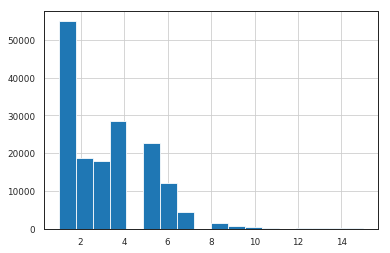

In [22]:
x.token.apply(len).hist(bins=18)

In [23]:
max_len_char = 10

In [24]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

49


In [25]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [26]:
X_char = []
for sentence in sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [27]:
splits_char = [train_test_split(X_char, y, test_size=0.25, random_state=42+i) for i in range(3)]

## fastText

In [28]:
!ls '../fasttext/'

src  wiki.he.vec


In [81]:
def get_embedding_matrix(path, embed_dim=300, MAX_NB_WORDS=100000):
    #load embeddings
    print('loading word embeddings...')
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('found %s word vectors' % len(embeddings_index))
    #embedding matrix
    print('preparing embedding matrix...')
    words_not_found = []
    nb_words = min(MAX_NB_WORDS, len(word2idx))
    embedding_matrix = np.zeros((nb_words, embed_dim))
    for word, i in word2idx.items():
        if i >= nb_words:
            continue
        embedding_vector = embeddings_index.get(word.strip('_'))
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append(word)
    print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    print("sample words not found: ", np.random.choice(words_not_found, 10))
    return embedding_matrix

In [83]:
embedding_matrix_ft_pt = get_embedding_matrix('../fasttext/wiki.he.vec')

loading word embeddings...
found 488937 word vectors
preparing embedding matrix...
number of null word embeddings: 1529
sample words not found:  ['טירמיס' '13.00' 'מקסיקאיים' 'איזמירלי' '8591' 'תועסק' 'שוקחתן' '2,162'
 'אלמולזינו' 'להתנאות']


In [ ]:
embedding_matrix = embedding_matrix_ft_pt

## Model building

In [33]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, Concatenate
from keras.layers.merge import concatenate

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, Concatenate
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras_contrib.layers import CRF
from keras_contrib.metrics import crf_accuracy
from keras_contrib.losses import crf_loss

In [ ]:
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [ ]:
def plot_histories(histories, crf=False, **kwargs):
    for h in histories:
        plt.figure()
        if crf:
            plt.plot(h["crf_accuracy"])
            plt.plot(h["val_crf_accuracy"]) 
        else:   
            plt.plot(h["acc"])
            plt.plot(h["val_acc"])
        plt.show()
        
def predict_test_sentence(splits, models, words, i, use_word=True, use_pos=True, use_char=False, **kwargs):
    for split, model in zip(splits, models):
        if use_char:
            split, char_split = split
            X_char_tr, X_char_te, _, _ = char_split
        X_tr, X_te, y_tr, y_te, pos_tr, pos_te = split
        params = []
        if use_word:
            params.append(np.array([X_te[i]]))
        if use_pos:
            params.append(np.array([pos_te[i]]))
        if use_char:
            params.append(np.array([X_char_te[i]]))
        p = model.predict(params)
        p = np.argmax(p, axis=-1)
        t = np.argmax(y_te[i], axis=-1)
        print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
        for w, pred, tr in zip(X_te[i], p[0], t):
            if idx2word[w]!="PAD":
                print("{:15} ({:5}): {}".format(idx2word[w], idx2tag[tr], idx2tag[pred]))
                
def predict_on_splits(splits, models, words, use_word=True, use_pos=False, use_char=False, predict_on_train=False, **kwargs):
    all_cat_preds = []
    all_cat_y_te = []
    all_words_flat = []
    for split, model in zip(splits, models):
        split, char_split = split
        X_char_tr, X_char_te, _, _ = char_split
        X_tr, X_te, y_tr, y_te, pos_tr, pos_te = split
        
        if predict_on_train:
            X_te, y_te, pos_te = X_tr, y_tr, pos_tr
        params = []
        if use_word:
            params.append(np.array(X_te))
        if use_pos:
            params.append(np.array(pos_te))
        if use_char:
            params.append(np.array(X_char_te))
        preds = model.predict(params)
        preds = np.argmax(preds, axis=-1)
        cat_preds = []
        cat_y_te = []
        words_flat = []
        y_te_num = np.argmax(y_te, axis=-1)
        for ws, s, t in zip(X_te, preds, y_te_num):
            for w, pred, tr in zip(ws, s, t):
                if idx2word[w]!="PAD":
                    words_flat.append(idx2word[w])
                    cat_preds.append(idx2tag[pred].replace('_', '-'))
                    cat_y_te.append(idx2tag[tr].replace('_', '-'))

        all_cat_preds.append(cat_preds)
        all_cat_y_te.append(cat_y_te)
        all_words_flat.append(words_flat)
        
    return (all_cat_preds, all_cat_y_te, all_words_flat)
    
def replace_pad_with_o(ll):
    new_ll = ['O' if label=='PAD' else label for label in ll]
    return new_ll

In [ ]:
def create_model(words, chars, use_word=True, use_pos=False, embedding_matrix=None, 
                       embed_dim=70, trainable=True, input_dropout=False, stack_lstm=1,
                       epochs=100, early_stopping=True, patience=20, min_delta=0.0001,
                       use_char=False, crf=False,
                       stack_cross=False, stack_double=False, rec_dropout=0.1,
                       verbose=1):

    X_tr, X_te, y_tr, y_te, pos_tr, pos_te = words
    X_char_tr, X_char_te, _, _ = chars
    all_input_embeds = []
    all_inputs = []
    train_data = []
    if use_word:
        input = Input(shape=(max_len,))
        if embedding_matrix is not None:
            input_embed = Embedding(input_dim=n_words+2, output_dim=embed_dim, input_length=max_len, 
                                weights=[embedding_matrix], trainable=trainable)(input)
        else:
            input_embed = Embedding(input_dim=n_words+2, output_dim=embed_dim, input_length=max_len)(input)
        all_input_embeds.append(input_embed)
        all_inputs.append(input)
        train_data.append(X_tr)
    if use_pos:
        pos_input = Input(shape=(max_len,))
        pos_embed = Embedding(input_dim=n_pos+1, output_dim=10, input_length=max_len)(pos_input)
        all_input_embeds.append(pos_embed)
        all_inputs.append(pos_input)
        train_data.append(pos_tr)
    if use_char:
        # input and embeddings for characters
        char_in = Input(shape=(max_len, max_len_char,))
        emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=20,
                                   input_length=max_len_char))(char_in)
        # character LSTM to get word encodings by characters
        char_enc = TimeDistributed(Bidirectional(LSTM(units=10, return_sequences=False,
                                        recurrent_dropout=0.5)))(emb_char)
        all_input_embeds.append(char_enc)
        all_inputs.append(char_in)
        train_data.append(np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)))
    if len(all_inputs)>1:
        model = Concatenate()(all_input_embeds)
        if (use_char):
            model = SpatialDropout1D(0.3)(model)
    else: 
        model = all_input_embeds[0]
        all_input_embeds = all_input_embeds[0]
        all_inputs = all_inputs[0]
        train_data = train_data[0]

    if input_dropout:
        model = Dropout(0.1)(model)

    if stack_double:
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(model)
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(front)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(model)
        model = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(back)
    if stack_cross:
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(model)
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(front)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(model)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(back)
        model = concatenate([back, front])
    for i in range(stack_lstm):
        model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout))(model)

    if crf:
        model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
        crf = CRF(n_tags+1)
        loss = crf_loss
        metric = crf_accuracy
        monitor = 'val_crf_accuracy'
        out = crf(model)
    else:
        out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)  # softmax output layer
        loss = "categorical_crossentropy"
        metric = 'accuracy'
        monitor = 'val_acc'

    model = Model(all_inputs, out)
    model.compile(optimizer="rmsprop", loss=loss, metrics=[metric])
    if early_stopping:
        es = [EarlyStopping(monitor=monitor, mode='max', verbose=1, patience=patience, restore_best_weights=True, min_delta=min_delta)]
    else:
        es=None
    history = model.fit(train_data, np.array(y_tr), batch_size=32, epochs=epochs, 
                        validation_split=0.1, verbose=verbose, callbacks=es)
    hist = pd.DataFrame(history.history)
        
    return model, hist


In [ ]:
def create_model(words, chars, use_word=True, use_pos=False, embedding_matrix=None, 
                       embed_dim=70, trainable=True, input_dropout=False, stack_lstm=1,
                       epochs=100, early_stopping=True, patience=20, min_delta=0.0001,
                       use_char=False, crf=False, add_random_embedding=False, pretrained_embed_dim=300,
                       stack_cross=False, stack_double=False, rec_dropout=0.1,
                       verbose=1):

    X_tr, X_te, y_tr, y_te, pos_tr, pos_te = words
    X_char_tr, X_char_te, _, _ = chars
    all_input_embeds = []
    all_inputs = []
    train_data = []
    if use_word and not add_random_embedding and embedding_matrix is None:
        raise ValueError('Cannot use word without embedding')
    if use_word:
        input = Input(shape=(max_len,))
        if add_random_embedding:
            input_embed = Embedding(input_dim=n_words+2, output_dim=embed_dim, input_length=max_len)(input)
            all_input_embeds.append(input_embed)
        if embedding_matrix is not None:
            input_embed = Embedding(input_dim=n_words+2, output_dim=pretrained_embed_dim, input_length=max_len, 
                                weights=[embedding_mats[embedding_matrix]], trainable=trainable)(input)
            all_input_embeds.append(input_embed)
        all_inputs.append(input)
        train_data.append(X_tr)
    if use_pos:
        pos_input = Input(shape=(max_len,))
        pos_embed = Embedding(input_dim=n_pos+1, output_dim=10, input_length=max_len)(pos_input)
        all_input_embeds.append(pos_embed)
        all_inputs.append(pos_input)
        train_data.append(pos_tr)
    if use_char:
        # input and embeddings for characters
        char_in = Input(shape=(max_len, max_len_char,))
        emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=20,
                                   input_length=max_len_char))(char_in)
        # character LSTM to get word encodings by characters
        char_enc = TimeDistributed(Bidirectional(LSTM(units=10, return_sequences=False,
                                        recurrent_dropout=0.5)))(emb_char)
        all_input_embeds.append(char_enc)
        all_inputs.append(char_in)
        train_data.append(np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)))
    if len(all_inputs)>1:
        model = Concatenate()(all_input_embeds)
        if (use_char):
            model = SpatialDropout1D(0.3)(model)
    else: 
        model = all_input_embeds[0]
        all_input_embeds = all_input_embeds[0]
        all_inputs = all_inputs[0]
        train_data = train_data[0]

    if input_dropout:
        model = Dropout(0.1)(model)

    if stack_double:
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(model)
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(front)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(model)
        model = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(back)
    if stack_cross:
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(model)
        front = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout)(front)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(model)
        back = LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout, go_backwards=True)(back)
        model = concatenate([back, front])
    for i in range(stack_lstm):
        model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=rec_dropout))(model)

    if crf:
        model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
        crf = CRF(n_tags+1)
        loss = crf_loss
        metric = crf_accuracy
        monitor = 'val_crf_accuracy'
        out = crf(model)
    else:
        out = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)  # softmax output layer
        loss = "categorical_crossentropy"
        metric = 'accuracy'
        monitor = 'val_acc'

    model = Model(all_inputs, out)
    model.compile(optimizer="rmsprop", loss=loss, metrics=[metric])
    if early_stopping:
        es = [EarlyStopping(monitor=monitor, mode='max', verbose=1, patience=patience, restore_best_weights=True, min_delta=min_delta)]
    else:
        es=None
    history = model.fit(train_data, np.array(y_tr), batch_size=32, epochs=epochs, 
                        validation_split=0.1, verbose=verbose, callbacks=es)
    hist = pd.DataFrame(history.history)
        
    return model, hist


In [ ]:
results = []
preds = []
histories = []

In [ ]:
configs = [
            #{'use_pos': False },
            #{'use_pos': True},
            #{'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            #{'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            #{'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': False},
            {'crf': True, 'use_pos': True},
            #{'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'use_char': True, 'use_word': False, 'use_pos': False },
            #{'use_char': True, 'use_word': False, 'use_pos': True},
            #{'use_char': True, 'use_pos': False },
            #{'use_char': True, 'use_pos': True},
            #{'use_char': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            #{'use_char': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'use_char': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            #{'use_char': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': False},
            {'use_char': True, 'crf': True, 'use_pos': True},
            #{'use_char': True, 'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'use_char': True, 'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
          ]

In [ ]:
configs = [
            #{'use_pos': False },
            #{'use_pos': True},
            #{'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            #{'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            #{'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': False},
            {'crf': True, 'use_pos': True},
            #{'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'use_char': True, 'use_word': False, 'use_pos': False },
            #{'use_char': True, 'use_word': False, 'use_pos': True},
            #{'use_char': True, 'use_pos': False },
            #{'use_char': True, 'use_pos': True},
            #{'use_char': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            #{'use_char': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'use_char': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            #{'use_char': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': False},
            {'use_char': True, 'crf': True, 'use_pos': True},
            #{'use_char': True, 'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': False, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
            #{'use_char': True, 'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': False, 'embed_dim': embed_dim},
            {'use_char': True, 'crf': True, 'use_pos': True, 'embedding_matrix': embedding_matrix, 'trainable': True, 'embed_dim': embed_dim},
          ]

Train on 4195 samples, validate on 467 samples
Epoch 1/100
4195/4195 [==============================] - 53s 13ms/step - loss: 0.3575 - crf_accuracy: 0.9284 - val_loss: 0.1620 - val_crf_accuracy: 0.9715
Epoch 2/100
4195/4195 [==============================] - 46s 11ms/step - loss: 0.1367 - crf_accuracy: 0.9704 - val_loss: 0.1916 - val_crf_accuracy: 0.9621
Epoch 3/100
4195/4195 [==============================] - 47s 11ms/step - loss: 0.0997 - crf_accuracy: 0.9735 - val_loss: 0.1016 - val_crf_accuracy: 0.9754
Epoch 4/100
4195/4195 [==============================] - 47s 11ms/step - loss: 0.0723 - crf_accuracy: 0.9787 - val_loss: 0.0798 - val_crf_accuracy: 0.9799
Epoch 5/100
4195/4195 [==============================] - 46s 11ms/step - loss: 0.0519 - crf_accuracy: 0.9833 - val_loss: 0.0789 - val_crf_accuracy: 0.9719
Epoch 6/100
4195/4195 [==============================] - 46s 11ms/step - loss: 0.0378 - crf_accuracy: 0.9857 - val_loss: 0.0583 - val_crf_accuracy: 0.9804
Epoch 7/100
4195/4195 [

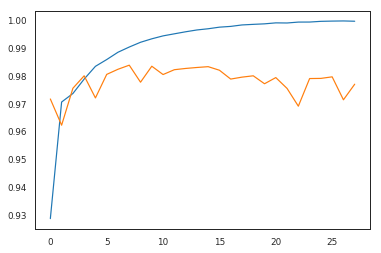

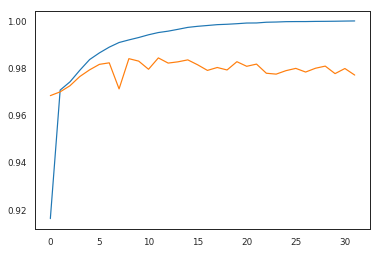

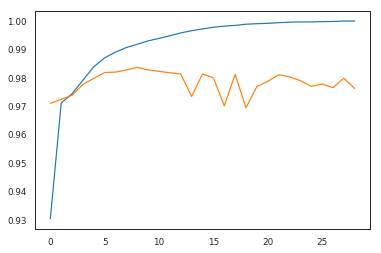

processed 39438 tokens with 1894 phrases; found: 1629 phrases; correct: 1085.
accuracy:  54.08%; (non-O)
accuracy:  94.77%; precision:  66.61%; recall:  57.29%; FB1:  61.60
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  81.36%; recall:  71.43%; FB1:  76.07  381
              LOC: precision:  31.82%; recall:  16.67%; FB1:  21.87  44
              ORG: precision:  53.83%; recall:  54.96%; FB1:  54.39  587
              PER: precision:  72.12%; recall:  65.73%; FB1:  68.78  617
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 40573 tokens with 1907 phrases; found: 1735 phrases; correct: 1175.
accuracy:  55.53%; (non-O)
accuracy:  95.01%; precision:  67.72%; recall:  61.62%; FB1:  64.52
        

In [ ]:
for conf in configs:
    mh = [create_model(split, char, **conf) for split, char in zip(splits, splits_char)]
    hists = [h for m, h in mh]
    models = [m for m, h in mh]
    plot_histories(hists, **conf)
    all_cat_preds, all_cat_y_te, all_words_flat = predict_on_splits(zip(splits, splits_char), models, words, **conf)
    all_cat_preds = [replace_pad_with_o(ll) for ll in all_cat_preds]
    res = []
    for cat_y_te, cat_preds in zip(all_cat_y_te, all_cat_preds):
        res.append(evaluate(cat_y_te, cat_preds))
    results.append(res)
    preds.append(all_cat_preds)
    histories .append(hists)
    

In [44]:
results

[[(66.60527931246163, 57.28616684266103, 61.595231336928755),
  (67.72334293948127, 61.61510225485055, 64.52498627127952),
  (66.27027027027027, 61.7632241813602, 63.93741851368971)],
 [(73.11243889190658, 71.06652587117213, 72.07496653279786),
  (74.6727376209448, 68.79916098584164, 71.61572052401746),
  (72.9381443298969, 71.28463476070529, 72.10191082802548)],
 [(77.7602523659306, 78.08870116156284, 77.9241306638567),
  (76.30753138075313, 76.50760356581017, 76.40743650170201),
  (81.04683195592285, 74.1057934508816, 77.42105263157893)],
 [(81.0481736368449, 80.83421330517423, 80.94105207507269),
  (80.71772897696839, 79.02464604090194, 79.8622151563328),
  (80.66496163682865, 79.44584382871537, 80.0507614213198)],
 [(80.94905792044662, 61.246040126715954, 69.73249173429517),
  (72.96969696969697, 63.13581541688515, 67.69749789148159),
  (70.72921978582356, 69.87405541561714, 70.29903699949315)],
 [(75.57702630166399, 74.34002111932418, 74.95342028214),
  (73.40534979423869, 74.8295

In [46]:
for c in configs:
    if 'embedding_matrix' in c:
        c.update({'embedding_matrix': 'fastext'}) 

In [47]:
defaults = {'use_word': True, 'use_pos': False, 'embedding_matrix': None, 
            'embed_dim': 70, 'trainable': True, 'input_dropout': False, 
            'stack_lstm': 1, 'epochs': 100, 'early_stopping': True, 'patience': 20, 
            'min_delta': 0.0001, 'use_char': False, 'crf': False, 'stack_cross': False, 
            'stack_double': False, 'rec_dropout': 0.1}

In [48]:
for conf in configs:
    conf.update({'use_morpheme': True})
    conf.update({'use_word': False})

    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]

In [49]:
list(zip(configs, results, histories))

[({'crf': True,
   'use_pos': False,
   'use_morpheme': True,
   'use_word': False,
   'embedding_matrix': None,
   'embed_dim': 70,
   'trainable': True,
   'input_dropout': False,
   'stack_lstm': 1,
   'epochs': 100,
   'early_stopping': True,
   'patience': 20,
   'min_delta': 0.0001,
   'use_char': False,
   'stack_cross': False,
   'stack_double': False,
   'rec_dropout': 0.1},
  [(66.60527931246163, 57.28616684266103, 61.595231336928755),
   (67.72334293948127, 61.61510225485055, 64.52498627127952),
   (66.27027027027027, 61.7632241813602, 63.93741851368971)],
  [    val_loss  val_crf_accuracy      loss  crf_accuracy
   0   0.162016          0.971520  0.357525      0.928409
   1   0.191645          0.962072  0.136715      0.970420
   2   0.101569          0.975375  0.099683      0.973489
   3   0.079794          0.979872  0.072350      0.978692
   4   0.078906          0.971895  0.051881      0.983287
   5   0.058325          0.980380  0.037783      0.985724
   6   0.057175     

In [52]:
def get_results_df(configs, results):
    dict_res = []
    for conf, res in zip(configs, results):
        dr = {}
        for i, r in enumerate(res):
            split_name = chr(ord('a')+i)
            dr['prec_'+split_name], dr['recall_'+split_name], dr['f1_'+split_name] = r
        dr.update(conf)
        dict_res.append(dr)
    rdf = (pd.DataFrame(dict_res)
           .assign(prec = lambda x: (x.prec_a + x.prec_b + x.prec_c)/3)
           .assign(recall = lambda x: (x.recall_a + x.recall_b + x.recall_c)/3)
           .assign(f1 = lambda x: (x.f1_a + x.f1_b + x.f1_c)/3))
    return rdf

In [53]:
res1 = pickle.load(open('treebank_results_1.pkl', 'rb'))

In [54]:
res2 = pickle.load(open('treebank_results_2_test25.pkl', 'rb'))

In [57]:
rdf1 = get_results_df([c for c, r, h in res1], [r for c, r, h in res1])

In [58]:
rdf2 = get_results_df([c for c, r, p, h in res2], [r for c, r, p, h in res2])

In [60]:
rdf2.head()

,crf,early_stopping,embed_dim,embedding_matrix,epochs,f1_a,f1_b,f1_c,input_dropout,min_delta,...,stack_double,stack_lstm,trainable,use_char,use_morpheme,use_pos,use_word,prec,recall,f1
0,True,True,70,None,100,61.595231,64.524986,63.937419,False,0.0001,...,False,1,True,False,True,False,False,66.866298,60.221498,63.352545
1,True,True,70,None,100,72.074967,71.615721,72.101911,False,0.0001,...,False,1,True,False,True,True,False,73.574440,70.383441,71.930866
2,True,True,300,fastext,100,77.924131,76.407437,77.421053,False,0.0001,...,False,1,True,False,True,False,False,78.371539,76.234033,77.250873
3,True,True,300,fastext,100,80.941052,79.862215,80.050761,False,0.0001,...,False,1,True,False,True,True,False,80.810288,79.768234,80.284676
4,True,True,70,None,100,69.732492,67.697498,70.299037,False,0.0001,...,False,1,True,True,True,False,False,74.882658,64.751970,69.243009


In [61]:
 (rdf2.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                63.4  71.9  69.2  75.0
fastext           77.3  80.3  82.0  83.3

In [63]:
 (rdf1.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                67.9  74.4  70.7  75.8
fastext           79.4  83.4  82.9  84.6